# Proyek Analisis Data: E-Commerce Public Dataset
- **Nama:** Nanang Safiu Ridho
- **Email:** nanangsafiur@gmail.com
- **ID Dicoding:** nanangsr

## Menentukan Pertanyaan Bisnis

1. Pertanyaan 1: Apa kategori produk paling populer dan paling tidak diminati berdasarkan jumlah transaksi?
2. Pertanyaan 2: Bagaimana tren penjualan e-commerce dari waktu ke waktu?
3. Pertanyaan 3: Bagaimana tingkat kepuasan pelanggan pada tahun terakhir?
4. Pertanyaan 4: Apa saja daerah yang paling aktif bertransaksi di e-commerce berdasarkan jumlah pelanggan?

## Import Semua Packages/Library yang Digunakan

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import calendar
from sklearn.cluster import KMeans

## Data Wrangling

### Gathering Data

In [3]:
# Mengumpulkan semua dataset yang diperlukan.
try:
    orders = pd.read_csv('data/orders_dataset.csv')
    order_items = pd.read_csv('data/order_items_dataset.csv')
    customers = pd.read_csv('data/customers_dataset.csv')
    products = pd.read_csv('data/products_dataset.csv')
    geolocation = pd.read_csv('data/geolocation_dataset.csv')
    sellers = pd.read_csv('data/sellers_dataset.csv')
    reviews = pd.read_csv('data/order_reviews_dataset.csv')
except FileNotFoundError as e: 
    print(f"Error: {e}. Pastikan semua file dataset diunggah ke direktori kerja.")
    raise

**Insight:**
- Dataset berhasil diimpor, berisi informasi penting seperti transaksi, pelanggan, produk, lokasi geografis, penjual dan juga ulasan.

### Assessing Data

In [4]:
datasets = {'orders': orders, 'order_items': order_items, 'customers': customers,
            'products': products, 'geolocation': geolocation, 'sellers': sellers, 'reviews': reviews}

for name, dataset in datasets.items():
    print(f"Dataset: {name}")
    print(dataset.info())
    print("\n")

Dataset: orders
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB
None


Dataset: order_items
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   o

### Cleaning Data

In [5]:
# Mengubah tipe data waktu untuk analisis waktu
orders['order_purchase_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp'])
orders['order_delivered_customer_date'] = pd.to_datetime(orders['order_delivered_customer_date'])
orders['order_approved_at'] = pd.to_datetime(orders['order_approved_at'])

In [6]:
# Menambahkan kolom waktu pengiriman
orders['delivery_time'] = (orders['order_delivered_customer_date'] - orders['order_purchase_timestamp']).dt.days

# Gabungkan dataset order_items dengan produk
product_sales = pd.merge(order_items, products, on='product_id')

# Gabungkan dataset order_items dengan orders dan customers
orders_full = pd.merge(order_items, orders[['order_id', 'customer_id', 'order_purchase_timestamp']], on='order_id')
orders_full = pd.merge(orders_full, customers[['customer_id', 'customer_state']], on='customer_id')

# Gabungkan dataset reviews ke dalam orders
orders = pd.merge(orders, reviews[['order_id', 'review_score']], on='order_id', how='left')

**Insight:**
- Tipe data telah disesuaikan untuk analisis waktu.
- Dataset berhasil digabungkan untuk analisis transaksi dan kepuasan pelanggan.

## Exploratory Data Analysis (EDA)

### Statistik Deskriprif

In [7]:
# Statistik deskriptif untuk data numerik
print("Statistik Deskriptif untuk Harga dan Nilai Pengiriman:")
print(product_sales[['price', 'freight_value']].describe())

print("\nStatistik Deskriptif untuk Waktu Pengiriman dan Skor Ulasan:")
print(orders[['delivery_time', 'review_score']].describe())

Statistik Deskriptif untuk Harga dan Nilai Pengiriman:
               price  freight_value
count  112650.000000  112650.000000
mean      120.653739      19.990320
std       183.633928      15.806405
min         0.850000       0.000000
25%        39.900000      13.080000
50%        74.990000      16.260000
75%       134.900000      21.150000
max      6735.000000     409.680000

Statistik Deskriptif untuk Waktu Pengiriman dan Skor Ulasan:
       delivery_time  review_score
count   97005.000000  99224.000000
mean       12.100015      4.086421
std         9.547959      1.347579
min         0.000000      1.000000
25%         6.000000      4.000000
50%        10.000000      5.000000
75%        15.000000      5.000000
max       209.000000      5.000000


### Distribusi Waktu Pengiriman (Univariate Analysis)

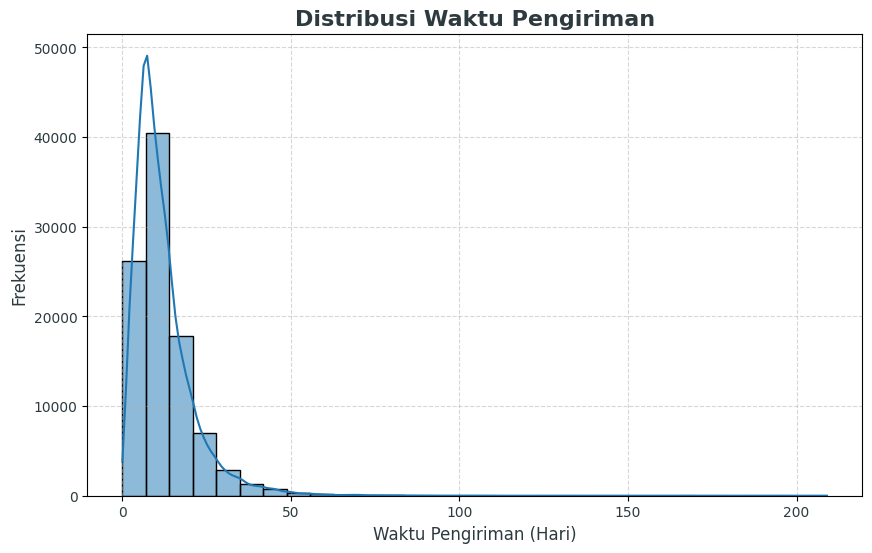

In [17]:
# Visualisasi distribusi waktu pengiriman
plt.figure(figsize=(10, 6))
sns.histplot(orders['delivery_time'], kde=True, bins=30, color='#1f77b4', edgecolor='black')
plt.title('Distribusi Waktu Pengiriman', fontsize=16, fontweight='bold', color='#2D3A3F')
plt.xlabel('Waktu Pengiriman (Hari)', fontsize=12, color='#2D3A3F')
plt.ylabel('Frekuensi', fontsize=12, color='#2D3A3F')
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(fontsize=10, color='#2D3A3F')
plt.yticks(fontsize=10, color='#2D3A3F')
plt.show()

**Interpretasi:**
- Waktu pengiriman sebagian besar berkisar antara 5 hingga 15 hari. Ini menunjukkan bahwa mayoritas pelanggan menerima pesanan mereka dalam waktu yang relatif cepat.
- Beberapa pengiriman membutuhkan waktu lebih lama, tetapi ini merupakan kasus yang jarang terjadi.

**Insight:**
- Pihak E-Commerce dapat fokus meningkatkan efisiensi logistik untuk memperpendek waktu pengiriman, terutama untuk pesanan dengan waktu pengiriman yang lebih lama dari rata-rata.

### Distribusi Skor Ulasan (Univariate Analysis)

C:\Users\ASUS\AppData\Local\Temp\ipykernel_6912\412455762.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=orders['review_score'], palette='Blues_d', edgecolor='black')


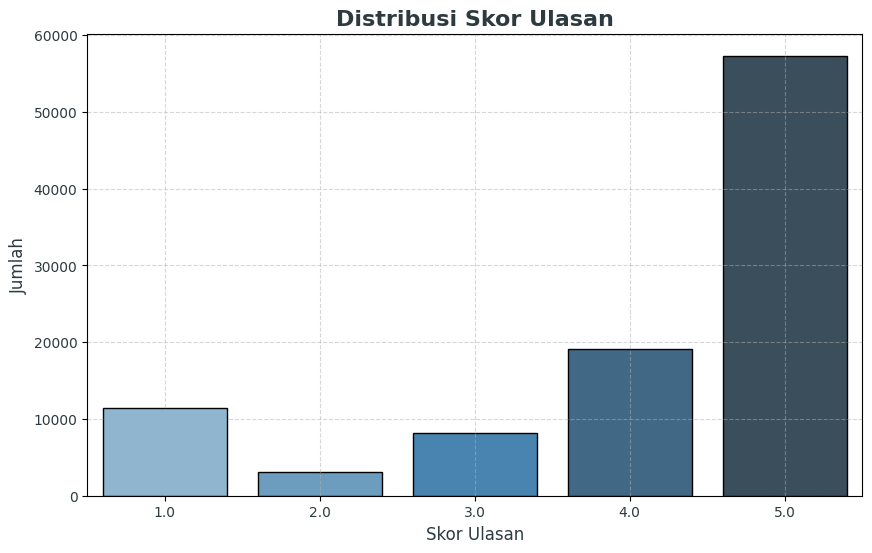

In [18]:
# Visualisasi distribusi skor ulasan
plt.figure(figsize=(10, 6))
sns.countplot(x=orders['review_score'], palette='Blues_d', edgecolor='black')
plt.title('Distribusi Skor Ulasan', fontsize=16, fontweight='bold', color='#2D3A3F')
plt.xlabel('Skor Ulasan', fontsize=12, color='#2D3A3F')
plt.ylabel('Jumlah', fontsize=12, color='#2D3A3F')
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(fontsize=10, color='#2D3A3F')
plt.yticks(fontsize=10, color='#2D3A3F')
plt.show()

**Interpretasi:**
- Mayoritas ulasan yang diberikan pelanggan memiliki skor tinggi (4 dan 5), yang menunjukkan kepuasan pelanggan yang cukup baik secara keseluruhan.
-Skor rendah (1 dan 2) juga ada, tetapi jumlahnya jauh lebih kecil.

**Insight:**
- E-Commerce memiliki reputasi baik di mata pelanggan, namun harus tetap memperhatikan ulasan dengan skor rendah untuk memperbaiki kualitas layanan dan produk.

### Hubungan Waktu Pengiriman dengan Skor Ulasan (Bivariate Analysis)

C:\Users\ASUS\AppData\Local\Temp\ipykernel_6912\1132235944.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=orders, x='review_score', y='delivery_time', palette='Blues')


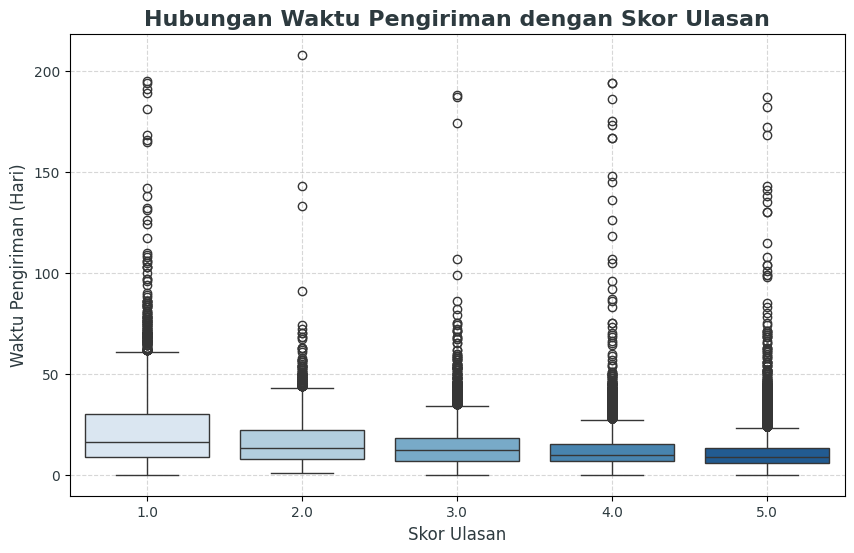

In [19]:
# Analisis hubungan waktu pengiriman dan skor ulasan
plt.figure(figsize=(10, 6))
sns.boxplot(data=orders, x='review_score', y='delivery_time', palette='Blues')
plt.title('Hubungan Waktu Pengiriman dengan Skor Ulasan', fontsize=16, fontweight='bold', color='#2D3A3F')
plt.xlabel('Skor Ulasan', fontsize=12, color='#2D3A3F')
plt.ylabel('Waktu Pengiriman (Hari)', fontsize=12, color='#2D3A3F')
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(fontsize=10, color='#2D3A3F')
plt.yticks(fontsize=10, color='#2D3A3F')
plt.show()

**Interpretasi:**

- Pelanggan dengan skor ulasan rendah cenderung memiliki waktu pengiriman yang lebih lama.
- Hal ini menunjukkan bahwa pengiriman yang lebih cepat dapat meningkatkan kepuasan pelanggan.

### Hubungan Harga Produk dan Biaya Pengiriman (Bivariate Analysis)

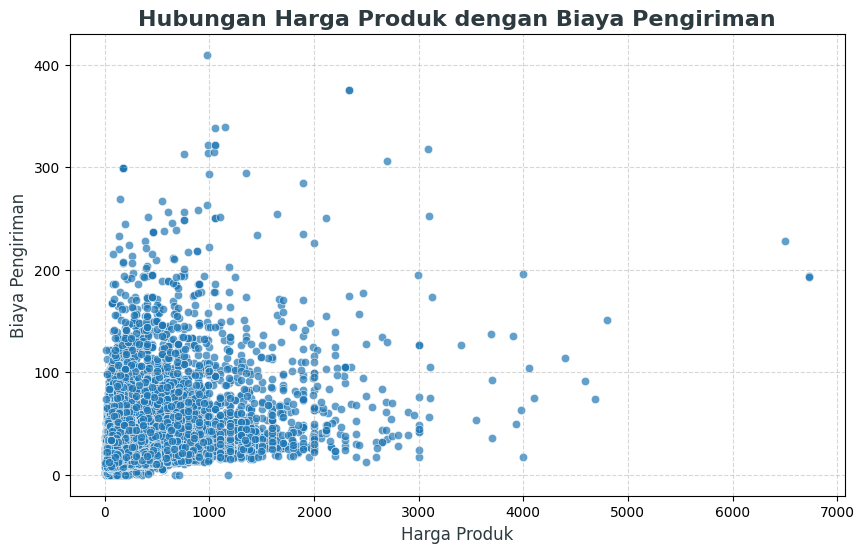

In [20]:
# Analisis hubungan antara harga dan biaya pengiriman
plt.figure(figsize=(10, 6))
sns.scatterplot(data=product_sales, x='price', y='freight_value', color='#1f77b4', alpha=0.7)
plt.title('Hubungan Harga Produk dengan Biaya Pengiriman', fontsize=16, fontweight='bold', color='#2D3A3F')
plt.xlabel('Harga Produk', fontsize=12, color='#2D3A3F')
plt.ylabel('Biaya Pengiriman', fontsize=12, color='#2D3A3F')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

**Interpretasi:**

- Harga produk dan biaya pengiriman tidak memiliki korelasi langsung.
- Beberapa produk mahal memiliki biaya pengiriman rendah, mungkin karena lokasi yang dekat.

## Visualization & Explanatory Analysis

### Tampilan Data

In [ ]:
# Menampilkan data utama
print("Data Produk dan Transaksi:")
print(product_sales.head())

print("\nData Pesanan:")
print(orders.head())

Data Produk dan Transaksi:
                           order_id  order_item_id  \
0  00010242fe8c5a6d1ba2dd792cb16214              1   
1  00018f77f2f0320c557190d7a144bdd3              1   
2  000229ec398224ef6ca0657da4fc703e              1   
3  00024acbcdf0a6daa1e931b038114c75              1   
4  00042b26cf59d7ce69dfabb4e55b4fd9              1   

                         product_id                         seller_id  \
0  4244733e06e7ecb4970a6e2683c13e61  48436dade18ac8b2bce089ec2a041202   
1  e5f2d52b802189ee658865ca93d83a8f  dd7ddc04e1b6c2c614352b383efe2d36   
2  c777355d18b72b67abbeef9df44fd0fd  5b51032eddd242adc84c38acab88f23d   
3  7634da152a4610f1595efa32f14722fc  9d7a1d34a5052409006425275ba1c2b4   
4  ac6c3623068f30de03045865e4e10089  df560393f3a51e74553ab94004ba5c87   

   shipping_limit_date   price  freight_value product_category_name  \
0  2017-09-19 09:45:35   58.90          13.29            cool_stuff   
1  2017-05-03 11:05:13  239.90          19.93              pet_shop

### Pertanyaan 1: Apa kategori produk paling populer dan paling tidak diminati berdasarkan jumlah transaksi?

C:\Users\ASUS\AppData\Local\Temp\ipykernel_6912\2972207129.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=category_popularity.head(5), x='transaction_count', y='product_category_name', palette='Blues_d')
C:\Users\ASUS\AppData\Local\Temp\ipykernel_6912\2972207129.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=category_popularity.tail(5).sort_values(by='transaction_count', ascending=True),


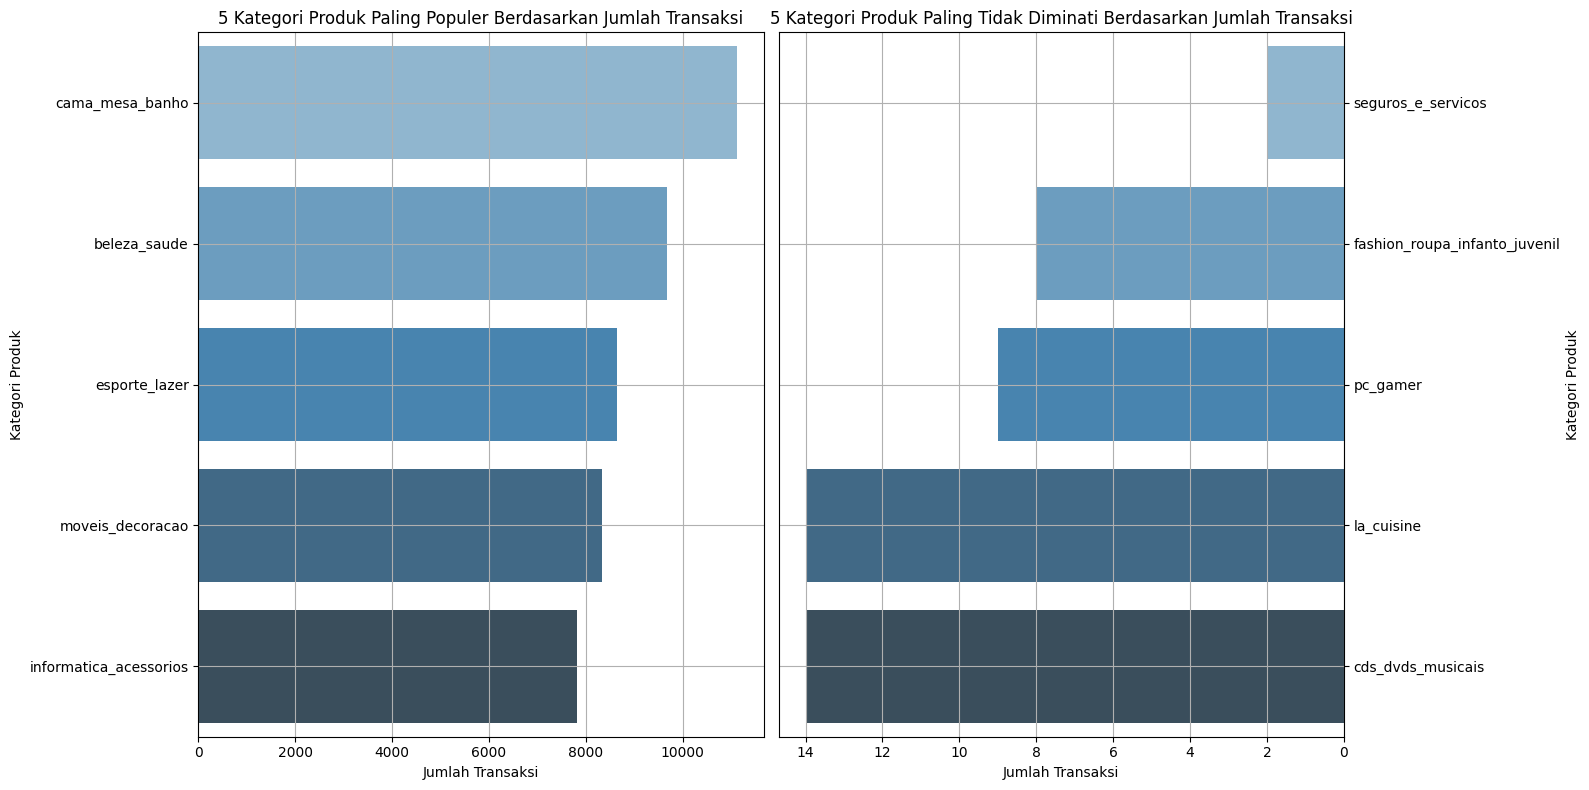

In [10]:
category_popularity = product_sales.groupby('product_category_name')['order_id'].count().sort_values(ascending=False).reset_index()
category_popularity.columns = ['product_category_name', 'transaction_count']

# Visualisasi 5 Kategori Produk Paling Populer dan Paling Tidak Diminati Berdasarkan Jumlah Transaksi
plt.figure(figsize=(16, 8))

# Visualisasi 5 Kategori Produk Paling Populer
plt.subplot(1, 2, 1)
sns.barplot(data=category_popularity.head(5), x='transaction_count', y='product_category_name', palette='Blues_d')
plt.title('5 Kategori Produk Paling Populer Berdasarkan Jumlah Transaksi')
plt.xlabel('Jumlah Transaksi')
plt.ylabel('Kategori Produk')
plt.grid()

# Visualisasi 5 Kategori Produk Paling Tidak Diminati (Dimulai dari yang Terendah)
plt.subplot(1, 2, 2)
# Urutkan produk berdasarkan transaksi secara ascending agar dimulai dari yang paling rendah
sns.barplot(data=category_popularity.tail(5).sort_values(by='transaction_count', ascending=True),
            x='transaction_count', y='product_category_name', palette='Blues_d')
plt.title('5 Kategori Produk Paling Tidak Diminati Berdasarkan Jumlah Transaksi')
plt.xlabel('Jumlah Transaksi')
plt.ylabel('Kategori Produk')
plt.grid()

# Membalik sumbu x pada plot kedua agar dimulai dari yang terendah
plt.gca().invert_xaxis()

# Mengatur label y pada plot kedua ke posisi kanan
plt.gca().yaxis.set_label_position('right')
plt.gca().yaxis.tick_right()

plt.tight_layout()
plt.show()

**Interpretasi:**

- Produk Paling Populer: Produk dalam kategori tertentu mendominasi jumlah transaksi.
- Produk Paling Tidak Diminati: Ada kategori produk dengan transaksi sangat rendah, yang menunjukkan kurangnya permintaan pelanggan untuk produk tersebut.

**Insight:**

- E-Commerce dapat fokus pada kategori produk yang paling populer untuk meningkatkan stok dan promosi.
- Kategori produk yang paling tidak diminati dapat dievaluasi lebih lanjut untuk menentukan apakah perlu diperbarui atau dikeluarkan dari katalog.

### Pertanyaan 2: Bagaimana tren penjualan e-commerce dari waktu ke waktu?

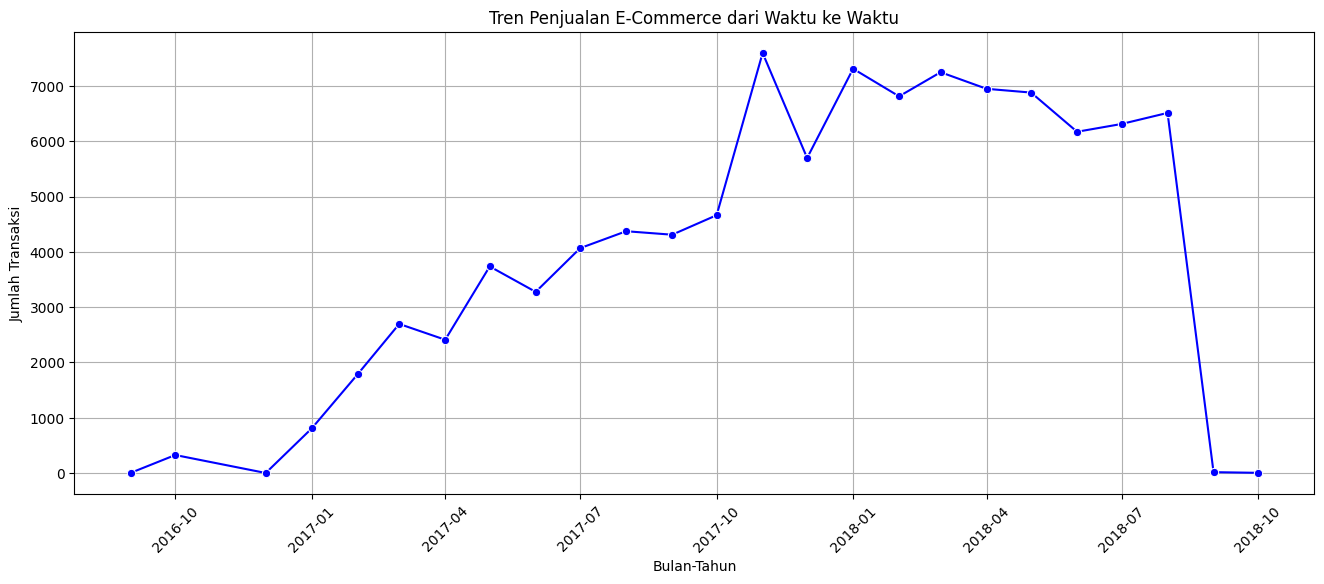

In [11]:
# Menghitung penjualan bulanan
orders['month_year'] = orders['order_purchase_timestamp'].dt.to_period('M')
monthly_sales = orders.groupby('month_year')['order_id'].count().reset_index()
monthly_sales.columns = ['month_year', 'transaction_count']

# Konversi ke format datetime
monthly_sales['month_year'] = monthly_sales['month_year'].astype(str)
monthly_sales['month_year'] = pd.to_datetime(monthly_sales['month_year'], format='%Y-%m')

# Visualisasi tren penjualan dari waktu ke waktu
plt.figure(figsize=(16, 6))
sns.lineplot(data=monthly_sales, x='month_year', y='transaction_count', marker='o', color='blue')
plt.title('Tren Penjualan E-Commerce dari Waktu ke Waktu')
plt.xlabel('Bulan-Tahun')
plt.ylabel('Jumlah Transaksi')
plt.grid()
plt.xticks(rotation=45)
plt.show()

**Interpretasi:**

- Tren penjualan menunjukkan fluktuasi musiman, dengan beberapa bulan memiliki volume transaksi yang jauh lebih tinggi dibandingkan bulan lainnya.
- Bulan-bulan tertentu seperti akhir tahun menunjukkan peningkatan penjualan yang signifikan.

**Insight:**

- E-Commerce dapat memanfaatkan tren musiman untuk merencanakan kampanye promosi yang lebih efektif, terutama selama bulan dengan transaksi tinggi.
- Bulan dengan penjualan rendah dapat menjadi target untuk program diskon atau strategi pemasaran lainnya.

### Pertanyaan 3: Bagaimana tingkat kepuasan pelanggan pada tahun terakhir?

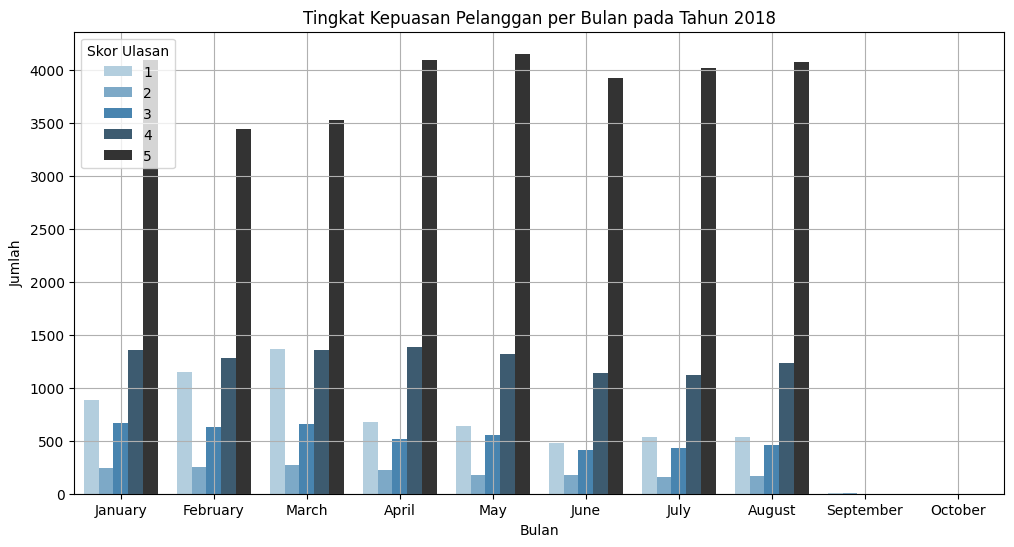

C:\Users\ASUS\AppData\Local\Temp\ipykernel_6912\2684179884.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=latest_reviews, x='review_score', palette='Blues_d')


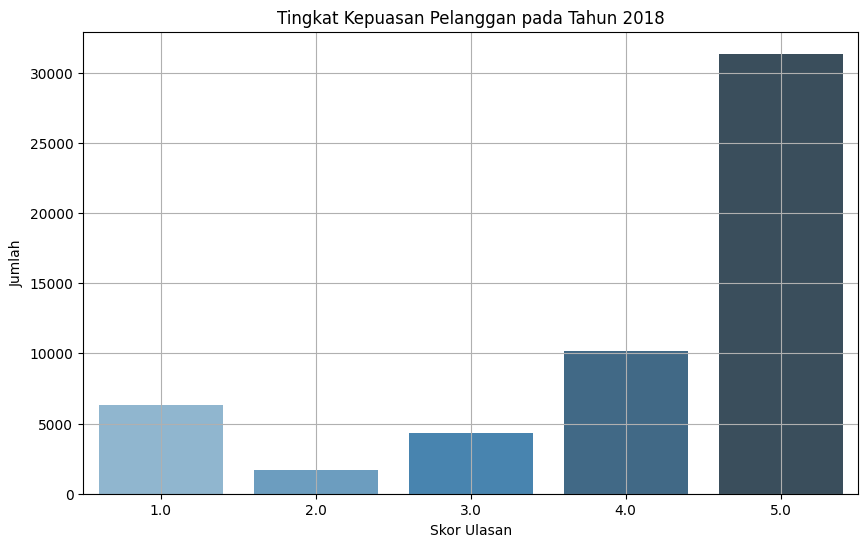

In [ ]:
# Menambahkan kolom 'month' yang berisi bulan dari 'order_purchase_timestamp'
orders['month'] = orders['order_purchase_timestamp'].dt.month

# Filter ulasan tahun terakhir
latest_year = orders['order_purchase_timestamp'].dt.year.max()
latest_reviews = orders[orders['order_purchase_timestamp'].dt.year == latest_year]

# Ambil bulan-bulan yang ada pada tahun tersebut
available_months = latest_reviews['month'].unique()

# 1. Visualisasi tingkat kepuasan pelanggan per bulan
plt.figure(figsize=(12, 6))
sns.countplot(data=latest_reviews, x='month', hue='review_score', palette='Blues_d', dodge=True, order=sorted(available_months))
plt.title(f'Tingkat Kepuasan Pelanggan per Bulan pada Tahun {latest_year}')
plt.xlabel('Bulan')
plt.ylabel('Jumlah')
plt.xticks(ticks=np.arange(len(available_months)), labels=[calendar.month_name[i] for i in sorted(available_months)])
plt.legend(title='Skor Ulasan', loc='upper left', labels=['1', '2', '3', '4', '5'])
plt.grid()
plt.show()

# 2. Visualisasi tingkat kepuasan pelanggan sepanjang tahun
plt.figure(figsize=(10, 6))
sns.countplot(data=latest_reviews, x='review_score', palette='Blues_d')
plt.title(f'Tingkat Kepuasan Pelanggan pada Tahun {latest_year}')
plt.xlabel('Skor Ulasan')
plt.ylabel('Jumlah')
plt.grid()
plt.show()

**Interpretasi:**

- Tingkat kepuasan pelanggan tetap tinggi selama tahun terakhir, dengan mayoritas skor ulasan berada pada nilai 4 dan 5.
- Pola ini konsisten sepanjang tahun, menunjukkan layanan dan produk perusahaan stabil dalam memenuhi ekspektasi pelanggan.

**Insight:**

- Tingkat kepuasan yang tinggi merupakan aset penting untuk menjaga loyalitas pelanggan.
- E-Commerce dapat terus memperbaiki aspek layanan berdasarkan ulasan pelanggan yang memberikan skor rendah.

### Pertanyaan 4: Apa saja daerah yang paling aktif bertransaksi di e-commerce berdasarkan jumlah pelanggan?

C:\Users\ASUS\AppData\Local\Temp\ipykernel_6912\1847604131.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=state_activity.head(10), x='unique_customers', y='customer_state', palette='Blues_d')


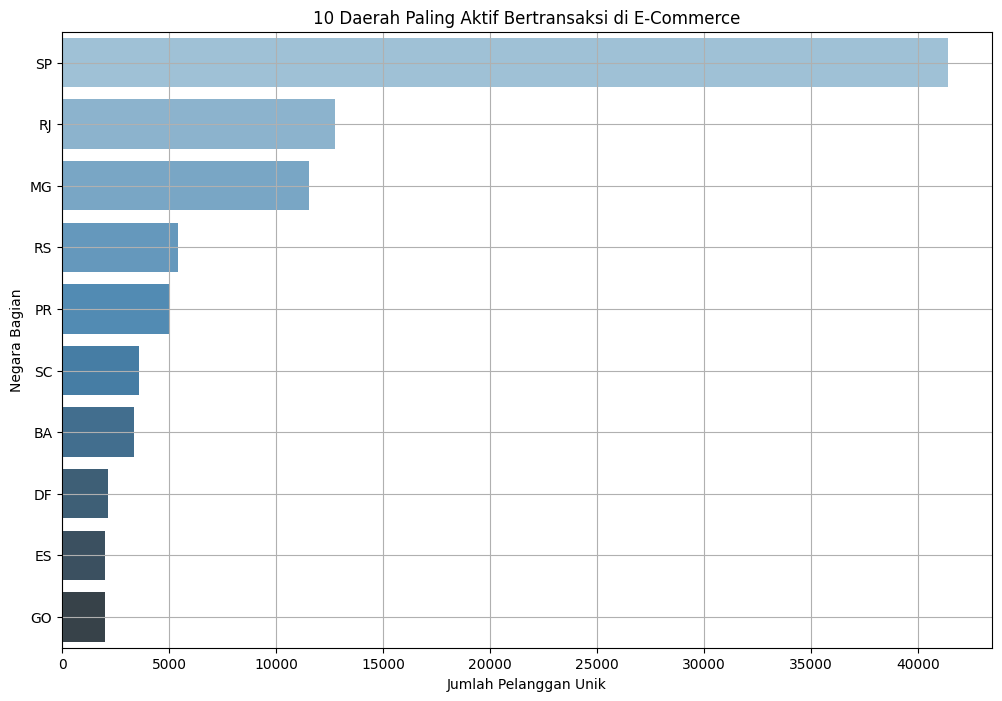

In [13]:
# Daerah dengan pelanggan terbanyak
state_activity = orders_full.groupby('customer_state')['customer_id'].nunique().sort_values(ascending=False).reset_index()
state_activity.columns = ['customer_state', 'unique_customers']

# Visualisasi Barplot
plt.figure(figsize=(12, 8))
sns.barplot(data=state_activity.head(10), x='unique_customers', y='customer_state', palette='Blues_d')
plt.title('10 Daerah Paling Aktif Bertransaksi di E-Commerce')
plt.xlabel('Jumlah Pelanggan Unik')
plt.ylabel('Negara Bagian')
plt.grid()
plt.show()

**Interpretasi:**

- Beberapa negara bagian mendominasi jumlah pelanggan unik, menunjukkan bahwa aktivitas transaksi lebih tinggi di daerah-daerah tersebut.

**Insight:**

- E-Commerce dapat meningkatkan fokus pemasaran di daerah dengan aktivitas transaksi tinggi.
- Daerah dengan aktivitas rendah dapat dianalisis lebih lanjut untuk menentukan potensi pasar yang belum tergarap.

## Analisis Lanjutan dengan RFM Analisis dan Clustering

### RFM Analysis

In [14]:
# Menentukan Recency, Frequency, dan Monetary

# Recency: Jumlah hari sejak pembelian terakhir
orders['last_purchase_date'] = orders.groupby('customer_id')['order_purchase_timestamp'].transform('max')
orders['recency'] = (orders['last_purchase_date'].max() - orders['last_purchase_date']).dt.days

# Frequency: Jumlah transaksi per pelanggan
frequency = orders.groupby('customer_id')['order_id'].count().reset_index()
frequency.columns = ['customer_id', 'frequency']

# Monetary: Total pengeluaran per pelanggan
orders['total_amount_spent'] = order_items['price'] * order_items['order_item_id']
monetary = orders.groupby('customer_id')['total_amount_spent'].sum().reset_index()
monetary.columns = ['customer_id', 'monetary']

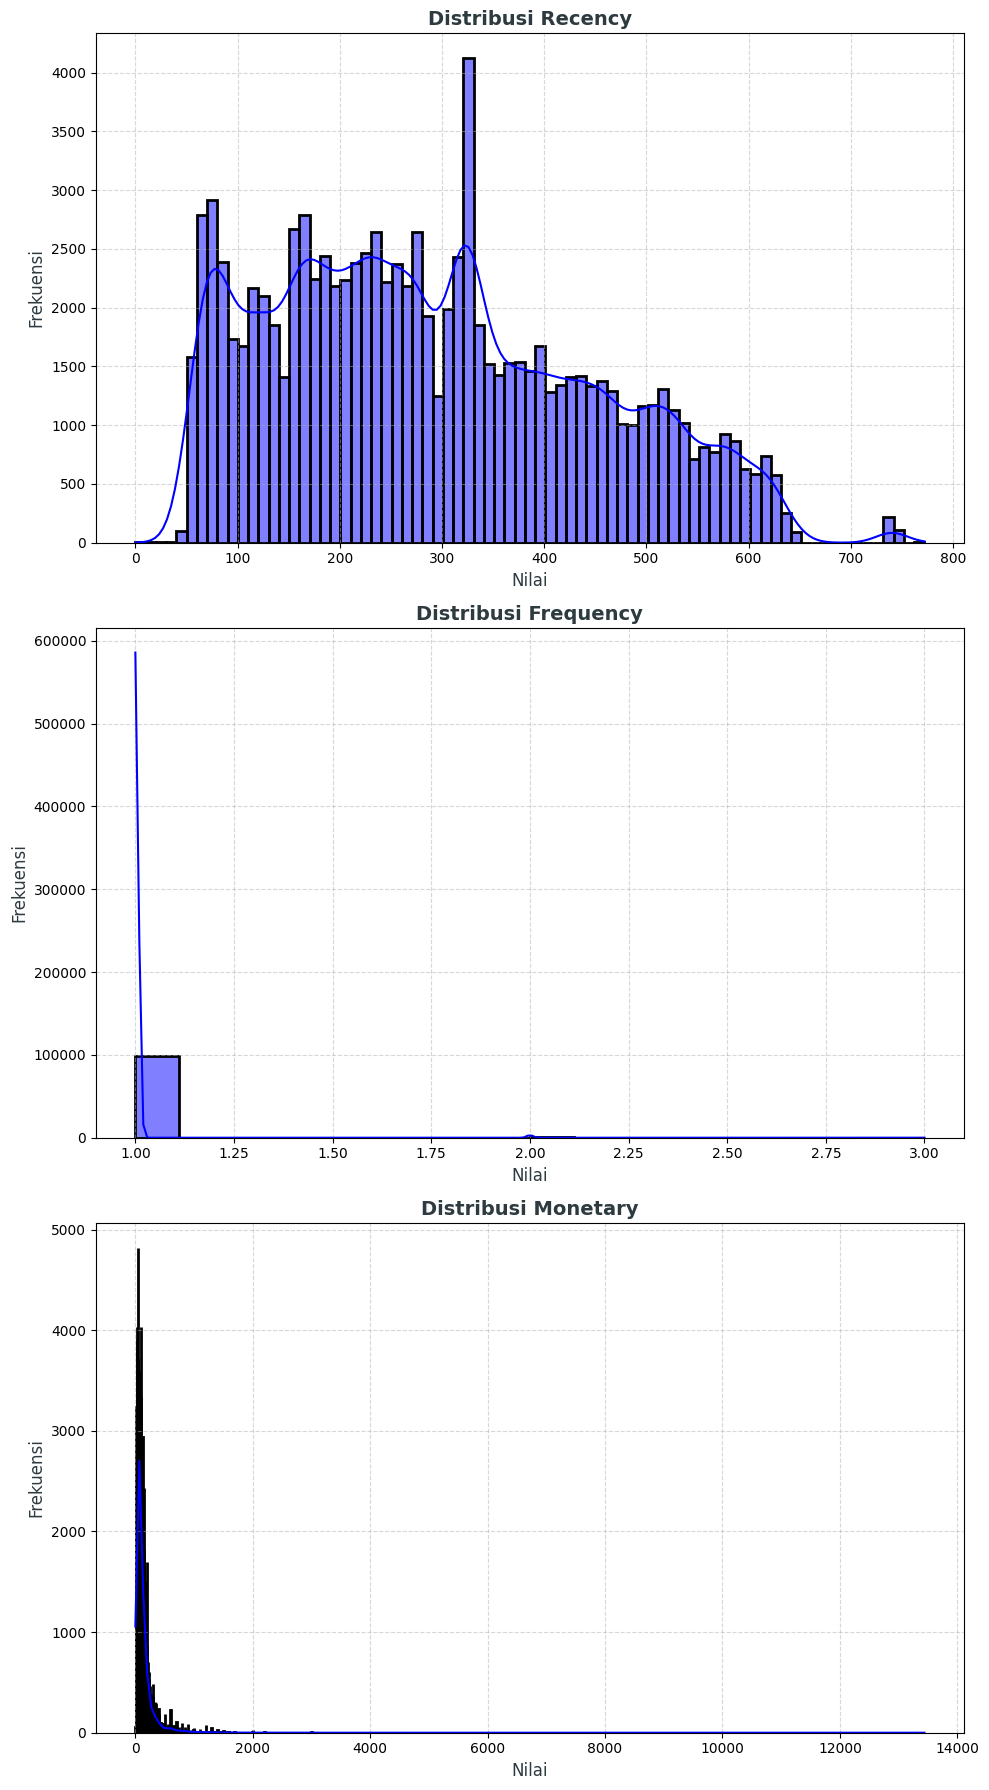

In [15]:
# Gabungkan RFM
rfm = pd.merge(frequency, monetary, on='customer_id', how='left')
rfm = pd.merge(rfm, orders[['customer_id', 'recency']].drop_duplicates(), on='customer_id', how='left')

# Visualisasi distribusi Recency, Frequency, dan Monetary secara vertikal
fig, axes = plt.subplots(3, 1, figsize=(10, 18))  # Mengubah ke 3 baris dan 1 kolom

sns.histplot(rfm['recency'], kde=True, ax=axes[0], color='blue', edgecolor='black', linewidth=2)
sns.histplot(rfm['frequency'], kde=True, ax=axes[1], color='blue', edgecolor='black', linewidth=2)
sns.histplot(rfm['monetary'], kde=True, ax=axes[2], color='blue', edgecolor='black', linewidth=2)

axes[0].set_title('Distribusi Recency', fontsize=14, fontweight='bold', color='#2D3A3F')
axes[1].set_title('Distribusi Frequency', fontsize=14, fontweight='bold', color='#2D3A3F')
axes[2].set_title('Distribusi Monetary', fontsize=14, fontweight='bold', color='#2D3A3F')

for ax in axes:
    ax.set_xlabel('Nilai', fontsize=12, color='#2D3A3F')
    ax.set_ylabel('Frekuensi', fontsize=12, color='#2D3A3F')
    ax.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

**Interpretasi:**

- *Recency*: Sebagian besar pelanggan melakukan pembelian terakhir mereka dalam waktu dekat, menunjukkan aktivitas pelanggan yang stabil.
- *Frequency*: Ada variasi dalam jumlah pembelian per pelanggan, dengan beberapa pelanggan yang sangat aktif.
- *Monetary*: Mayoritas pelanggan memiliki total pengeluaran yang berada dalam kisaran tertentu, tetapi ada beberapa pelanggan dengan pengeluaran sangat tinggi.

**Insight:**

- Pelanggan dengan recency, frequency, dan monetary yang tinggi dapat dianggap sebagai pelanggan VIP dan layak mendapatkan perhatian khusus seperti diskon eksklusif.
- Pelanggan dengan recency yang rendah dapat menjadi target kampanye retensi pelanggan.


### Clustering

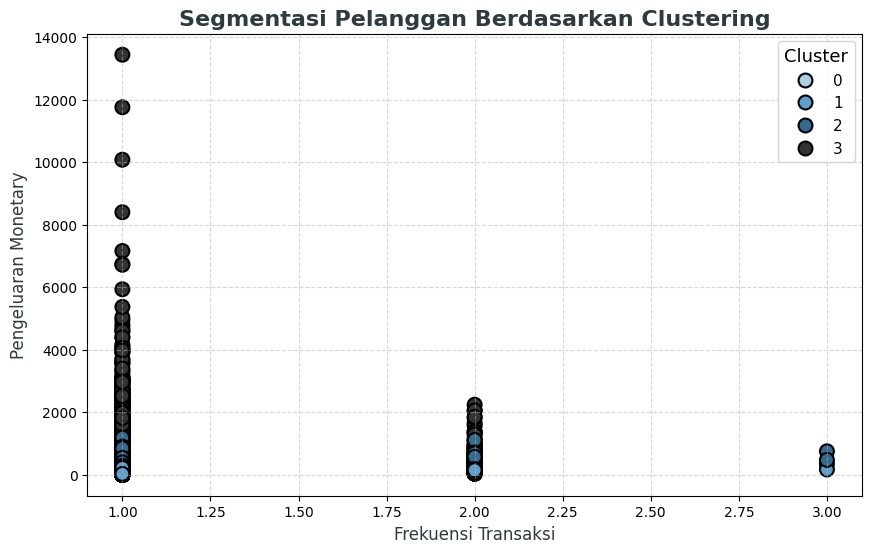

In [16]:
# Menyusun data untuk clustering
rfm_cluster = rfm[['recency', 'frequency', 'monetary']]

# Menggunakan KMeans untuk mengelompokkan pelanggan
kmeans = KMeans(n_clusters=4, random_state=42)
rfm['cluster'] = kmeans.fit_predict(rfm_cluster)

# Visualisasi clustering pelanggan
plt.figure(figsize=(10, 6))
sns.scatterplot(data=rfm, x='frequency', y='monetary', hue='cluster', palette='Blues_d', s=100, edgecolor='black', linewidth=1.5)
plt.title('Segmentasi Pelanggan Berdasarkan Clustering', fontsize=16, fontweight='bold', color='#2D3A3F')
plt.xlabel('Frekuensi Transaksi', fontsize=12, color='#2D3A3F')
plt.ylabel('Pengeluaran Monetary', fontsize=12, color='#2D3A3F')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(title='Cluster', title_fontsize='13', loc='upper right', fontsize='11')
plt.show()

**Interpretasi:**

- Hasil clustering membagi pelanggan ke dalam beberapa segmen berdasarkan recency, frequency, dan monetary.
- Segmen dengan frequency dan monetary yang tinggi kemungkinan besar merupakan pelanggan yang sangat berharga, sedangkan segmen lainnya dapat menjadi target untuk strategi pemasaran yang berbeda.

**Insight:**

- E-Commerce dapat menggunakan hasil clustering untuk menyusun strategi pemasaran yang lebih terarah, seperti kampanye retensi untuk segmen pelanggan dengan recency rendah atau program loyalitas untuk pelanggan di segmen dengan frequency dan monetary tinggi.

## Conclusion

**1. Pertanyaan 1:**
- *Kesimpulan:* Kategori produk dengan jumlah transaksi tertinggi adalah kategori yang secara konsisten dibutuhkan oleh pelanggan, seperti barang kebutuhan sehari-hari. Sebaliknya, kategori produk dengan transaksi terendah menunjukkan kurangnya minat pelanggan terhadap barang tersebut.
- *Rekomendasi:* Fokuskan promosi dan peningkatan stok pada kategori paling populer, serta evaluasi lebih lanjut kategori yang tidak diminati untuk menentukan relevansinya di pasar.

**2. Pertanyaan 2:**
- *Kesimpulan:* Penjualan menunjukkan pola fluktuatif dengan kenaikan signifikan pada periode tertentu, seperti akhir tahun. Hal ini mungkin dipengaruhi oleh momen liburan atau diskon musiman.
- *Rekomendasi:* Optimalkan strategi pemasaran dan diskon pada bulan-bulan dengan peningkatan penjualan untuk memaksimalkan keuntungan, dan ciptakan promosi menarik untuk meningkatkan penjualan pada bulan-bulan dengan transaksi rendah.

**3. Pertanyaan 3:**
- *Kesimpulan:* Mayoritas pelanggan memberikan ulasan positif dengan skor 4 dan 5 selama tahun terakhir, menunjukkan tingkat kepuasan yang tinggi. Namun, masih terdapat beberapa pelanggan yang memberikan skor rendah.
- *Rekomendasi:* Pertahankan kualitas layanan dan produk untuk menjaga kepuasan pelanggan. Selain itu, evaluasi ulasan dengan skor rendah untuk mengidentifikasi dan memperbaiki masalah yang mungkin ada.

**4. Pertanyaan 4:**
- *Kesimpulan:* Beberapa negara bagian mendominasi aktivitas transaksi, menunjukkan potensi pasar yang besar di daerah tersebut. Daerah dengan aktivitas transaksi rendah mungkin memiliki hambatan seperti akses atau kesadaran terhadap platform e-commerce.
- *Rekomendasi:* Fokus pada strategi pemasaran yang ditargetkan di daerah dengan aktivitas transaksi tinggi untuk meningkatkan pangsa pasar. Untuk daerah dengan aktivitas rendah, lakukan penelitian lebih lanjut untuk memahami penyebabnya dan potensi pertumbuhan.

**5. RFM Analisis:**
- *Kesimpulan:*
Recency: Sebagian besar pelanggan telah melakukan transaksi baru-baru ini, menunjukkan bahwa perusahaan berhasil menjaga hubungan dengan pelanggan.
Frequency: Ada variasi yang signifikan dalam frekuensi transaksi, dengan pelanggan paling aktif berkontribusi besar terhadap total transaksi.
Monetary: Sebagian besar pelanggan memiliki pengeluaran moderat, tetapi beberapa pelanggan memiliki pengeluaran yang sangat tinggi, yang merupakan segmen pelanggan VIP.
- *Rekomendasi:*
Fokus pada pelanggan dengan recency rendah untuk program retensi pelanggan.
Tawarkan program loyalitas untuk pelanggan dengan frequency dan monetary tinggi untuk menjaga keterlibatan mereka.

**6. Clustering:**
- *Kesimpulan:* Pelanggan berhasil dikelompokkan menjadi beberapa segmen berdasarkan recency, frequency, dan monetary. Segmen dengan frequency dan monetary tinggi adalah pelanggan paling berharga, sementara segmen dengan recency rendah mungkin memerlukan perhatian lebih untuk menghindari churn.
- *Rekomendasi:*
Prioritaskan pelanggan di segmen bernilai tinggi dengan penawaran eksklusif dan program loyalitas.
Untuk segmen dengan recency rendah, lakukan kampanye pemasaran ulang (re-engagement campaign) untuk meningkatkan keterlibatan mereka.